<a href="https://colab.research.google.com/github/martinpius/Computer-Vission/blob/main/Multiple_outputs_keras_model_a_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are on CoLab with tensorflow version: {tf.__version__}")
except Exception as e:
  print(f"{type(e)}: {e}\n...please load your drive...")
  COLAB = False
def time_fmt(t:float = 123.4567)->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60))
  s = int(t % 60)
  return f"{h}: {m:>03}: {s:>05.2f}"
print(f">>>time testing:>>>{time_fmt()}")

Mounted at /content/drive
You are on CoLab with tensorflow version: 2.4.1
>>>time testing:>>>0: 123: 03.00


In [ ]:
#We train a CNN model with multiple outputs on mnist dataset.
import time, os
import tensorflow as tf
import numpy as np
import pandas as pd
pd.set_option('max_rows', 8)
pd.set_option('max_columns', 0)


In [ ]:
#We start by read-in the data downloaded from kaggle website:

In [ ]:
os.chdir("/content/drive/MyDrive/archive (1)")
train_dfm = pd.read_csv('train.csv')
test_dfm = pd.read_csv('test.csv')

In [ ]:
#Get the image files
train_imgs = os.getcwd() + "/train_images/" + train_dfm.iloc[:,0].values
test_imgs = os.getcwd() + "/test_images/" + test_dfm.iloc[:,0].values

In [ ]:
display(train_dfm)

,Image,first_num,second_num
0,0_00.png,0,0
1,100_00.png,0,0
2,101_00.png,0,0
3,102_00.png,0,0
...,...,...,...
63996,998_98.png,9,8
63997,999_98.png,9,8
63998,99_98.png,9,8
63999,9_98.png,9,8


In [ ]:
display(test_dfm)

,Image,first_num,second_num
0,0_02.png,0,2
1,100_02.png,0,2
2,101_02.png,0,2
3,102_02.png,0,2
...,...,...,...
19996,998_96.png,9,6
19997,999_96.png,9,6
19998,99_96.png,9,6
19999,9_96.png,9,6


In [ ]:
#As we see from the above, our dataframe consists of 3 columns for images, first and second number:
#We are required to build a cnn-model to accurately predict the digits at the same time

In [ ]:
#Extracting the labels from the above dataframes:

In [ ]:
train_label = train_dfm.iloc[:,1:].values
test_label = test_dfm.iloc[:,1:].values

In [ ]:
print(f"train labels sample:\n {train_label[0:3]}, test label sample:\n {test_label[0:3]}")

train labels sample:
 [[0 0]
 [0 0]
 [0 0]], test label sample:
 [[0 2]
 [0 2]
 [0 2]]


In [ ]:
#The following function read and decode the images then return each image and its
#corresponding labels (each image has two labels on it)
def _img_read_decode(img_path,label):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_image(img, channels = 1, dtype = tf.float32)
  img.set_shape((64,64,1))
  label[0].set_shape([])
  label[1].set_shape([])
  labels = {'first_num': label[0], 'second_num': label[1]}
  return img, labels

In [ ]:
#We now convert the data into tensorflow data-types for easy streaming:
EPOCHS = 2
BUFFER_SIZE = len(train_label)
my_setup = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
train_data = tf.data.Dataset.from_tensor_slices((train_imgs, train_label))
train_data = train_data.shuffle(BUFFER_SIZE).map(_img_read_decode).batch(batch_size = BATCH_SIZE, drop_remainder = True).prefetch(my_setup)

In [ ]:
validation_data = tf.data.Dataset.from_tensor_slices((test_imgs, test_label))
validation_data = validation_data.shuffle(BUFFER_SIZE).map(_img_read_decode).batch(batch_size = BATCH_SIZE, drop_remainder = True).prefetch(my_setup)


In [ ]:
#Now we are ready to Build our multi-output keras model to predict the double digit mnist dataset

In [ ]:
#Defining the convolutional block
class ConvBlock(tf.keras.layers.Layer):
  def __init__(self, num_filters, kernel = 3, *args, **kwargs):
    super(ConvBlock, self).__init__(*args, **kwargs)
    self.conv = tf.keras.layers.Conv2D(filters = num_filters, kernel_size = kernel, activation = 'relu',padding = 'same')
    self.bn = tf.keras.layers.BatchNormalization()
  
  def call(self, inputs, training = False):
    x = self.conv(inputs)
    x = self.bn(x)
    return x
 

In [ ]:
#Building the model:
inputs = tf.keras.Input(shape = (64,64,1))
x = ConvBlock(64)(inputs)
x = ConvBlock(128)(x)
x = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(x)
x = ConvBlock(256)(x)
x = ConvBlock(512)(x)
x = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(x)
x = ConvBlock(256)(x)
x = ConvBlock(64)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units = 1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(rate = 0.5)(x)
x = tf.keras.layers.Dense(units = 512, activation = 'relu')(x)
out1 = tf.keras.layers.Dense(units = 10, activation = 'softmax', name = 'first_num')(x)
out2 = tf.keras.layers.Dense(units = 10, activation = 'softmax', name = 'second_num')(x)
model = tf.keras.Model(inputs = inputs, outputs = [out1, out2], name = 'cnn_multiple')


Model: "cnn_multiple"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv_block (ConvBlock)          (None, 64, 64, 64)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv_block_1 (ConvBlock)        (None, 64, 64, 128)  74368       conv_block[0][0]                 
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 128)  0           conv_block_1[0][0]               
_______________________________________________________________________________________

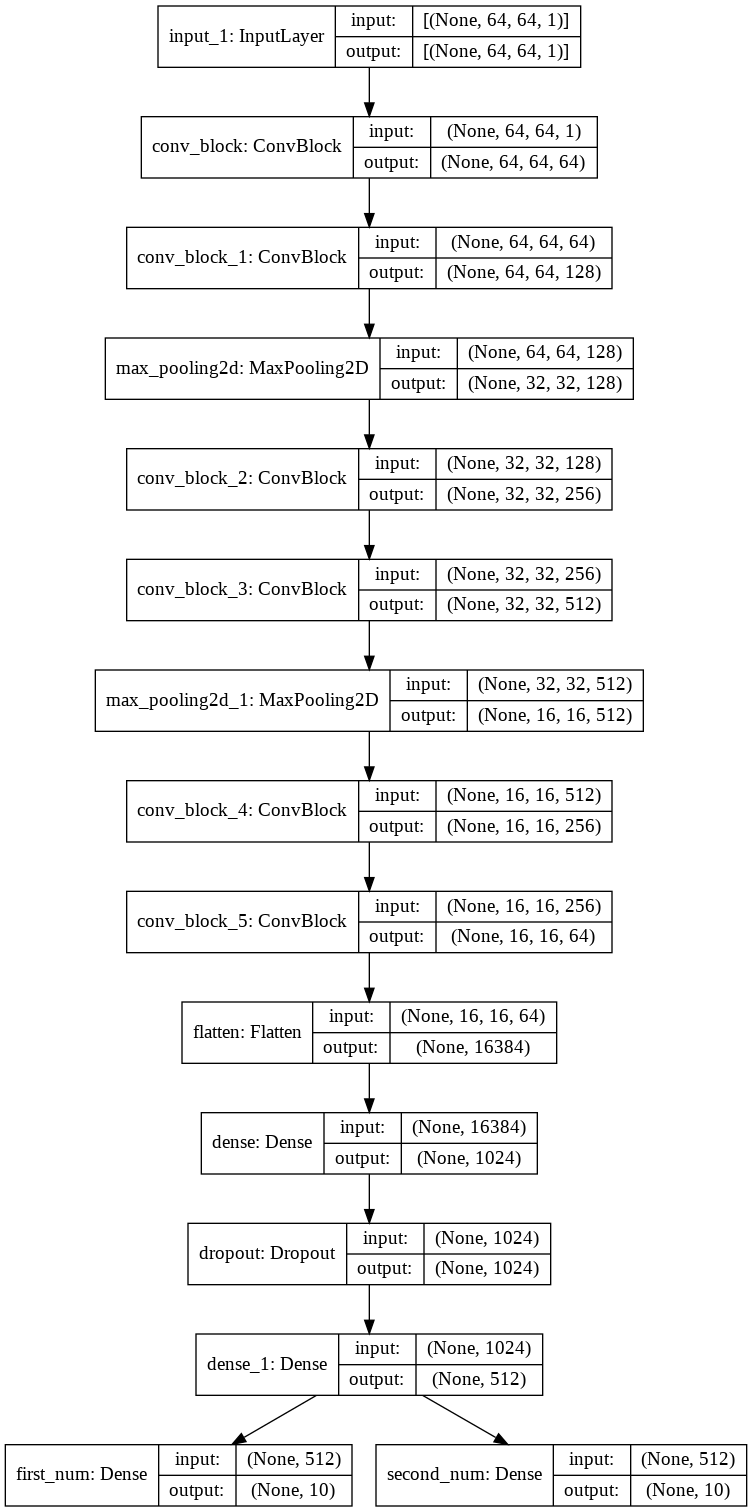

In [ ]:
#Get the summary and the vissual graph of the model
model.summary()
tf.keras.utils.plot_model(model = model, to_file = 'cnn_multiple.png', show_shapes = True)

In [ ]:
#The training loop from scratch:


In [ ]:
model.compile(optimizer = 'RMSprop',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
tic = time.time()
model.fit(train_data, epochs = EPOCHS, verbose = 2,batch_size= BATCH_SIZE)
model.evaluate(validation_data, batch_size = BATCH_SIZE, verbose = 2)
toc = time.time()
print(f"time_elapse: {time_fmt(toc - tic)}")


Epoch 1/2
